In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from umap import UMAP
from bertopic import BERTopic
import hdbscan
import re
import json

In [4]:
class ProductGroupGenerator:
    def __init__(self, min_cluster_size=5, max_clusters=75):
        self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.tfidf = TfidfVectorizer(
            max_features=1000,
            stop_words='english',
            ngram_range=(1, 2)
        )
        self.min_cluster_size = min_cluster_size
        self.max_clusters = max_clusters
        
    def preprocess_text(self, text):
        # Convert to lowercase and remove special characters
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(text).lower())
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
        
    def generate_clusters(self, texts, method='combined', n_clusters=None):
        """
        Generate product clusters using different methods
        
        Args:
            texts: List of product titles/descriptions
            method: One of 'tfidf_kmeans', 'bert_topic', or 'combined'
            n_clusters: Optional target number of clusters
        """
        if n_clusters is None:
            n_clusters = min(len(texts) // self.min_cluster_size, self.max_clusters)
            
        processed_texts = [self.preprocess_text(text) for text in texts]
        
        if method == 'tfidf_kmeans':
            return self._cluster_tfidf_kmeans(processed_texts, n_clusters)
        elif method == 'bert_topic':
            return self._cluster_bert_topic(processed_texts)
        elif method == 'combined':
            return self._cluster_combined(processed_texts, n_clusters)
        else:
            raise ValueError("Invalid clustering method")
    
    def _cluster_tfidf_kmeans(self, texts, n_clusters):
        # Transform texts to TF-IDF vectors
        tfidf_matrix = self.tfidf.fit_transform(texts)
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(tfidf_matrix)
        
        # Get top terms for each cluster
        cluster_terms = {}
        feature_names = self.tfidf.get_feature_names_out()
        for i in range(n_clusters):
            center_indices = kmeans.cluster_centers_[i].argsort()[::-1][:5]
            cluster_terms[i] = [feature_names[idx] for idx in center_indices]
            
        return labels, cluster_terms
    
    def _cluster_bert_topic(self, texts):
        # Create embeddings
        embeddings = self.sentence_model.encode(texts)
        
        # Initialize BERTopic
        topic_model = BERTopic(
            umap_model=UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine'),
            hdbscan_model=hdbscan.HDBSCAN(
                min_cluster_size=self.min_cluster_size,
                min_samples=1,
                metric='euclidean',
                cluster_selection_method='eom'
            ),
            verbose=True
        )
        
        # Fit the model and get topics
        labels, _ = topic_model.fit_transform(texts, embeddings)
        
        # Get topic terms
        topic_terms = {}
        for topic_idx, words in topic_model.get_topics().items():
            topic_terms[topic_idx] = [word[0] for word in words[:5]]
            
        return labels, topic_terms
    
    def _cluster_combined(self, texts, n_clusters):
        # Get clusters from both methods
        print("CLUSTERING BY KMEANS")
        kmeans_labels, kmeans_terms = self._cluster_tfidf_kmeans(texts, n_clusters)
        print("CLUSTERING BY BERT")
        bert_labels, bert_terms = self._cluster_bert_topic(texts)
        
        # Create ensemble clustering
        # Convert labels to one-hot encoding
        def one_hot_encode(labels):
            n_unique = len(np.unique(labels))
            return np.eye(n_unique)[labels]
        
        kmeans_oh = one_hot_encode(kmeans_labels)
        bert_oh = one_hot_encode(bert_labels)
        
        # Concatenate features
        combined_features = np.hstack([kmeans_oh, bert_oh])
        
        # Final clustering on combined features
        print("CREATING FINAL CLUSTERING COMBINATION")
        final_kmeans = KMeans(n_clusters=n_clusters)
        final_labels = final_kmeans.fit_predict(combined_features)
        
        # Combine terms from both methods for final clusters
        final_terms = {}
        for i in range(n_clusters):
            terms_set = set()
            terms_set.update(kmeans_terms.get(i, []))
            terms_set.update(bert_terms.get(i, []))
            final_terms[i] = list(terms_set)[:5]
            
        return final_labels, final_terms

    def analyze_clusters(self, texts, labels, cluster_terms):
        """
        Analyze cluster quality and characteristics
        """
        cluster_stats = {}
        unique_labels = np.unique(labels)
        
        for label in unique_labels:
            cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == label]
            cluster_stats[label] = {
                'size': len(cluster_texts),
                'terms': cluster_terms.get(label, []),
                'sample_products': cluster_texts[:3]  # Show 3 example products
            }
            
        return cluster_stats

In [5]:
# Prepare your data
products_df = pd.read_csv("C:/Users/benja/Desktop/Improving_Mp_Search/beauty_and_personal_care_filtered.csv")
texts = products_df['title'] + ' ' + products_df['description']

In [6]:
# Initialize clustering class
generator = ProductGroupGenerator(min_cluster_size=100, max_clusters = 100)

In [7]:
# Run clustering
labels, cluster_terms = generator.generate_clusters(texts, method='bert_topic')

2025-03-01 14:28:16,008 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-01 14:28:35,511 - BERTopic - Dimensionality - Completed ✓
2025-03-01 14:28:35,522 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-01 14:28:37,461 - BERTopic - Cluster - Completed ✓
2025-03-01 14:28:37,473 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-01 14:28:41,538 - BERTopic - Representation - Completed ✓


In [8]:
# Analyze the clusters
cluster_stats = generator.analyze_clusters(texts, labels, cluster_terms)

In [9]:
# Number of total products
products_df.shape[0] 

18274

In [10]:
# Number of clusters
len(cluster_stats)

68

In [11]:
# Sample of group sizes and key terms
for i in range(10):
    print(f"Cluster Size: {cluster_stats[i]['size']}")
    print(f"Key Terms: {', '.join(cluster_stats[i]['terms'])}\n")

Cluster Size: 1789
Key Terms: hair, shampoo, conditioner, and, oil

Cluster Size: 823
Key Terms: trimmer, shaver, blades, blade, electric

Cluster Size: 492
Key Terms: wig, wigs, lace, human, front

Cluster Size: 365
Key Terms: makeup, brush, brushes, sponge, foundation

Cluster Size: 354
Key Terms: iron, curling, heat, straightener, ceramic

Cluster Size: 346
Key Terms: polish, gel, nail, coat, lamp

Cluster Size: 344
Key Terms: serum, skin, vitamin, hyaluronic, acid

Cluster Size: 327
Key Terms: nail, art, glitter, rhinestones, stickers

Cluster Size: 320
Key Terms: clips, hair, bun, claw, pins

Cluster Size: 306
Key Terms: foundation, makeup, coverage, concealer, skin



In [12]:
num_items = []

for cluster in cluster_stats.keys():
    num_items.append(cluster_stats[cluster]['size'])

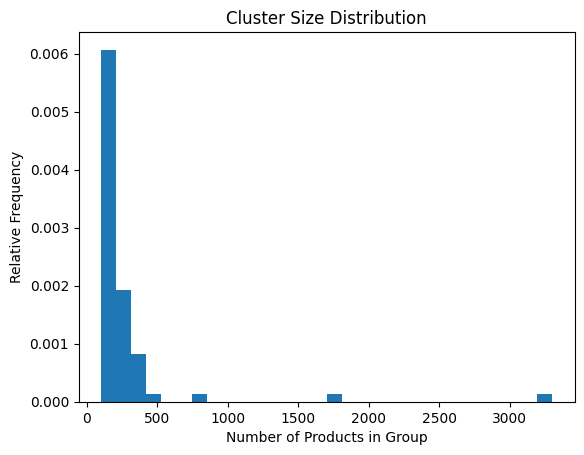

In [13]:
plt.hist(num_items, bins=30, density=True)
plt.title("Cluster Size Distribution")
plt.xlabel("Number of Products in Group")
plt.ylabel("Relative Frequency")
plt.show()

In [14]:
products_df['label'] = labels
products_df['label'].value_counts()[:5]

label
-1    3302
 0    1789
 1     823
 2     492
 3     365
Name: count, dtype: int64

In [15]:
for i in range(len(cluster_stats)-1):
    print(cluster_stats[i]['terms'])

['hair', 'shampoo', 'conditioner', 'and', 'oil']
['trimmer', 'shaver', 'blades', 'blade', 'electric']
['wig', 'wigs', 'lace', 'human', 'front']
['makeup', 'brush', 'brushes', 'sponge', 'foundation']
['iron', 'curling', 'heat', 'straightener', 'ceramic']
['polish', 'gel', 'nail', 'coat', 'lamp']
['serum', 'skin', 'vitamin', 'hyaluronic', 'acid']
['nail', 'art', 'glitter', 'rhinestones', 'stickers']
['clips', 'hair', 'bun', 'claw', 'pins']
['foundation', 'makeup', 'coverage', 'concealer', 'skin']
['mirror', 'makeup', 'magnification', 'lighted', 'vanity']
['soap', 'bar', 'body', 'wash', 'hand']
['acne', 'skin', 'acid', 'face', 'salicylic']
['sunscreen', 'spf', 'sun', 'protection', 'spectrum']
['deodorant', 'antiperspirant', 'odor', 'protection', 'sweat']
['nails', 'nail', 'tips', 'fake', 'false']
['extensions', 'ponytail', 'hair', 'clip', 'extension']
['headbands', 'headband', 'head', 'women', 'bands']
['foot', 'feet', 'socks', 'cracked', 'mask']
['notes', 'fragrance', 'perfume', 'scent',

In [16]:
cluster_terms = {i: cluster_stats[i]['terms'] for i in range(-1, len(cluster_stats)-1)}

In [17]:
with open("C:/Users/benja/Desktop/Improving_Mp_Search/beauty_and_personal_care_key_terms.json", "w") as f:
    json.dump(cluster_terms, f)

In [18]:
products_df.head()

,id,title,description,label
0,B01ALT5MKW,Babo Botanicals Sheer Zinc Continuous Spray Su...,Get the comfort of a lotion sunscreen and the ...,13
1,B0C5Z7V77F,SUNATORIA Keratin Hair Mask - Professional Tre...,Restorative Hair Mask with Hydrolyzed Keratin ...,0
2,B0BZJ5LDZ6,[Farewell] Sunny I Tip Hair Extensions Natural...,SpecificationsSunny I tip hair extensions are ...,16
3,B09MTGTV3G,Vvan Long Straight Hair Ombre Green Straight W...,Basic information 1Hair MaterialHeat Resistant...,2
4,B0722JDG4Q,"Makeup Bag,Leather Double Layer Large Makeup O...",Durable Makeup Bag Travel Accessories for Wome...,47


In [20]:
products_df.to_csv("C:/Users/benja/Desktop/Improving_Mp_Search/labeled_beauty_and_personal_care_products.csv", index=False)